Import python libraries:

In [57]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime as datetime
import matplotlib.pyplot as plt
import config as cfg
from alpaca.trading import TradingClient
from alpaca.trading.stream import TradingStream
from alpaca.trading import MarketOrderRequest
from alpaca.trading.enums import OrderSide, TimeInForce

from scipy.interpolate import UnivariateSpline

Define function to pull ticker price history:

In [ ]:
def get_ticker_history(ticker):

    stock = yf.Ticker(ticker)
    stock.info
    history = stock.history(period="1mo")

    df = pd.DataFrame(history)
    df.reset_index(inplace=True)
    
    df.drop(['High','Low','Dividends','Stock Splits'], axis=1, inplace=True)
    df.rename(columns={'Open': 'open_price', 'Close': 'close_price', 'Volume': 'volume'}, inplace=True)

    #clean up
    df['open_price'] = np.round(df['open_price'],2)
    df['close_price'] = np.round(df['close_price'],2)
    df['date_numeric'] = df.index + 1
    df['date'] = (df['Date']).dt.date

    #calculate new columns
    df['ticker'] = f'{ticker}'
    df['price_delta'] = df['close_price'] - df['open_price']

    #return desired columns
    df = df[['ticker', 'open_price', 'close_price', 'price_delta', 'date', 'date_numeric']]

    return(df)

Print the first few rows of our dataframe:

In [59]:
ex_table = get_ticker_history("NVDA")
print(ex_table.head(5))

  ticker  open_price  close_price  price_delta        date  date_numeric
0   NVDA      750.21       785.34        35.13  2024-02-22             1
1   NVDA      807.86       788.13       -19.73  2024-02-23             2
2   NVDA      796.96       790.88        -6.08  2024-02-26             3
3   NVDA      793.77       786.97        -6.80  2024-02-27             4
4   NVDA      776.16       776.59         0.43  2024-02-28             5


Plot the data in our dataframe:

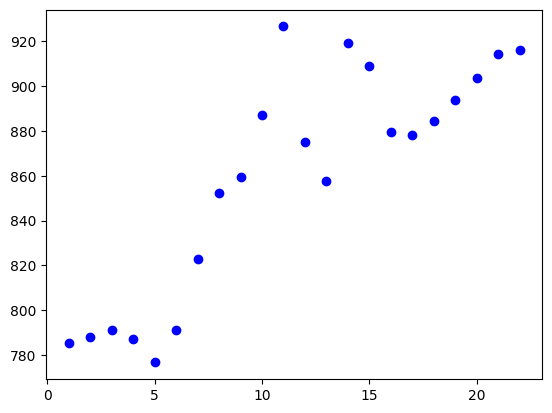

In [60]:
df = get_ticker_history("NVDA")
plt.scatter(df['date_numeric'], df['close_price'], label='Original Data', color='blue')
plt.show()

Here's what the fitted curve looks like visually:

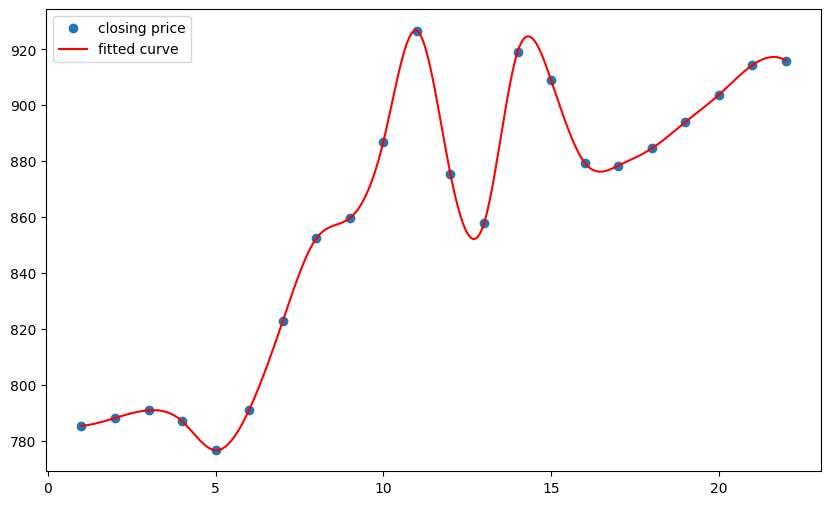

In [61]:
df = get_ticker_history("NVDA")

x = df['date_numeric']
y = df['close_price']

spline = UnivariateSpline(x, y, s=0, k=3)

x_smooth = np.linspace(x.min(), x.max(), 300)
y_smooth = spline(x_smooth)

plt.figure(figsize=(10, 6))
plt.plot(x, y, 'o', label='closing price')  # Original data points
plt.plot(x_smooth, y_smooth, '-', label='fitted curve', color='red')  # Smooth curve
plt.legend()
plt.show()

Create a new function to calculate the 2nd derivative of fitted curve at each closing price:

In [62]:
def calculate_d2ydx2(ticker):
    
    df = get_ticker_history(ticker)
    spline = UnivariateSpline(df['date_numeric'], df['close_price'], s=0, k=3)
    df['d2ydx2'] = spline.derivative(n=2)(df['date_numeric'])    
    df = (df[['ticker','date','close_price','d2ydx2','date_numeric']])

    return(df)

Now we've got the 2nd derivative at each closing price:

In [63]:
ex_table = calculate_d2ydx2("NVDA")
ex_table = ex_table.sort_values(by='date_numeric', ascending=False)

print(ex_table.head(5))

   ticker        date  close_price     d2ydx2  date_numeric
21   NVDA  2024-03-22       915.98 -22.084776            22
20   NVDA  2024-03-21       914.35  -9.000000            21
19   NVDA  2024-03-20       903.72   4.084776            20
18   NVDA  2024-03-19       893.98  -1.999104            19
17   NVDA  2024-03-18       884.55   5.771639            18


Generate a buy or sell signal based on the current second derivative in the function:

In [64]:
def generate_signal(ticker):

    df = calculate_d2ydx2(ticker)
    date_current = df['date_numeric'].max()

    result = df.loc[df['date_numeric'] == date_current, 'd2ydx2'].item()

    if result > 0:
        return 1 #buy
    else:
        return 0 #sell

Test our function:

In [65]:
generate_signal('NVDA')

0

(If the most recent d2ydx2 is negative, we expect a sell signal, vice versa)

Create trading function to trade user's tickers:

In [66]:
def qualify_tickers(tickers):
    
    input_tickers = tickers
    ticker_df = pd.DataFrame(columns=['ticker','signal'])

    for i in input_tickers:
        
        signal = generate_signal(i)

        new_row = {'ticker': i, 'signal': signal}
        ticker_df = pd.concat([ticker_df, pd.DataFrame([new_row])], ignore_index=True)

    return(ticker_df)

In [67]:
ex_tickers = ['NVDA','MSFT','GME','AMD','TSM','AAPL'] 

result_df = qualify_tickers(ex_tickers)
print(result_df)

  ticker signal
0   NVDA      0
1   MSFT      0
2    GME      1
3    AMD      1
4    TSM      0
5   AAPL      1


Now we can generate buy or sell signals from a user's input list, but we need to connect to a platform's API to place buy and sell orders.

In [ ]:
# This is before I knew how to properly use environment variables.
api_key = cfg.api_key
secret_key = cfg.secret_key
base_url = cfg.base_url

trading_client = TradingClient(api_key, secret_key, paper=True)

# test client connection
#acc = dict(trading_client.get_account())
#for k,v in acc.items():
#    print(k,v)


Create a function to return our current positions in a dataframe:

In [69]:
def get_positions():

    all_positions = trading_client.get_all_positions()
    
    curr_positions = pd.DataFrame(all_positions)
    
    if len(curr_positions) >= 1:
        df = curr_positions[[1]].rename(columns={1: 'ticker'})
        df['ticker'] = df['ticker'].apply(lambda x: x[1] if isinstance(x, tuple) and len(x) > 1 else None)
        symbol_list = df['ticker'].tolist()
        return(symbol_list)
    else:
        symbol_list = ['']
        return(symbol_list)

get_positions()

['AAPL', 'GME', 'GOOG']

Define our buy and sell functions:

In [ ]:
api_key = cfg.api_key
secret_key = cfg.secret_key

trades = TradingStream(api_key, secret_key, paper=True)

def place_buys(tickers):

    # get current positions in case we need to sell / don't buy anything we already have a current position in
    curr_positions = get_positions()
    algo_df = qualify_tickers(tickers)
    filtered_df = algo_df[~algo_df['ticker'].isin(curr_positions)]
    qualified_list = filtered_df['ticker'].tolist()

    print('Tickers being qualified for buys: ',qualified_list)

    order_dollars = 2500

    for row in filtered_df.itertuples(index=False):

        ticker_symbol = row.ticker
        ticker_signal = row.signal
        
        # place a buy order if signal is a buy signal
        if ticker_signal == 1: 
            
            market_order_data = MarketOrderRequest(
                symbol = ticker_symbol,
                notional = order_dollars,
                side=OrderSide.BUY,
                time_in_force=TimeInForce.DAY
            )
            
            trading_client.submit_order(
                order_data=market_order_data
            )

            print('Buy order placed for ticker: ',ticker_symbol)
        else:
            print('No buy order placed for ticker: ',ticker_symbol,', did not meet defined criteria.')

def place_sells():

    curr_positions = get_positions()
    print('Current open positions: ',curr_positions)

    if any(item for item in curr_positions if item != ""): #only run close logic if we have positions to close
        algo_df = qualify_tickers(curr_positions)

        # we only want to sell if we have an open position and we get a sell flag, otherwise we'll stay in the position
        for row in algo_df.itertuples(index=False):

            ticker_symbol = row.ticker
            ticker_signal = row.signal
        
            # place a buy order if signal is a buy signal
            if ticker_signal == 0: 
                
                trading_client.close_position(symbol_or_asset_id=ticker_symbol)

                print('Position closed for ticker: ',ticker_symbol)
    else:
        print('No positions to close')


Now we can excecute the bot with an input list of tickers and use the same logic to close any undesired positions based on our strategy:

In [56]:
user_input = ['NVDA','MSFT','GME','TSM','AAPL','GOOG']

def place_orders(tickers):
    place_buys(tickers)
    place_sells()

place_orders(user_input)

Tickers being qualified:  ['GME', 'TSM', 'AAPL', 'GOOG']
Buy order placed for ticker:  GME
No buy order placed for ticker:  TSM , did not meet defined criteria.
Buy order placed for ticker:  AAPL
Buy order placed for ticker:  GOOG
Current positions:  ['MSFT', 'NVDA']
Position closed for ticker:  MSFT
Position closed for ticker:  NVDA
